# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf


In [3]:
data_splits = ["train", "valid", "test", "complete"]
data_dict = load_data(data_splits, dataset="L1000")

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
# Prepare data for training

meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [5]:
#shuffle columns
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(94440, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.74578,-0.007757,-0.063908,-0.115210,0.83776,-0.80023,-0.25787,-0.621180,-0.53313,-0.260430,...,-0.458550,0.51684,2.86550,-0.152210,-0.907810,1.47600,-0.42918,-0.81612,0.28533,0.37183
1,-0.29710,-0.180930,0.482090,-0.337130,-0.47045,-0.44483,0.38475,-0.566390,0.27726,0.000645,...,0.008161,-0.33238,-0.20174,-0.605390,0.024792,0.60759,0.41555,0.50640,0.23908,-0.23696
2,-0.75812,-0.283820,0.594330,0.089136,-0.85230,-0.78754,0.20291,0.018564,-0.22745,-0.839810,...,0.289560,0.16598,0.54440,-0.053607,0.439350,0.42920,-0.37040,-0.51931,-0.21799,-1.29360


In [8]:
print(valid_features_df.shape)
valid_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.534400,0.552700,0.000000,-0.95760,-0.3264,-0.25560,0.00000,0.00000,1.88250,1.86290,...,5.22050,-0.96970,-1.133800,-1.079700,-2.29810,0.8493,0.29560,0.84640,0.19020,-0.47540
1,-0.029159,0.039928,0.045024,0.26740,-1.0234,0.58926,0.57561,0.60793,0.33281,-0.65153,...,-0.25789,0.46169,0.022211,-0.035998,0.67575,2.2909,0.24359,-0.14676,-0.84884,-0.16919
2,0.365290,-1.311300,-0.153500,0.72378,-1.1094,-0.38681,1.05910,0.12169,-1.01300,0.83094,...,-0.22982,-0.21314,-0.088198,0.527700,0.49855,-1.3877,1.00980,-0.21835,0.16329,-0.79029


In [9]:
print(test_features_df.shape)
test_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.28158,1.6038,-1.58650,-0.41677,-2.34260,3.12320,-0.10233,1.62600,0.115840,-0.000233,...,-0.49069,-1.14930,-0.16539,0.49864,1.077800,1.66230,-1.66900,-0.49738,0.51629,1.08940
1,0.77369,1.0853,0.75758,1.04900,1.18270,0.69324,-0.43503,-0.88949,-0.075833,0.208990,...,0.10747,0.97814,0.85407,0.10528,-0.370430,0.89069,-0.26969,-0.98646,-1.07350,0.48240
2,0.63079,1.9072,-1.65190,0.26266,0.68423,-0.38400,1.63160,0.78741,0.732920,-2.431700,...,-1.83770,-0.56064,0.93692,0.96585,-0.036786,1.35430,2.15870,-0.28158,0.53111,-0.46053


In [10]:
print(complete_features_df.shape)
complete_features_df.head(3)

(118050, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,4.26410,0.057249,-2.13930,-0.22178,-0.37656,1.91380,0.065576,-0.86895,-0.10227,0.00000,...,5.246200,0.057058,-1.25620,-0.025255,0.168860,-1.639100,0.68510,-0.41942,1.71610,-0.47234
1,-0.38221,0.304310,-0.99592,-0.67083,-0.64824,0.62161,0.889530,0.20376,0.19481,-0.45637,...,0.206690,-0.010866,-0.87206,-0.223750,0.074144,0.093595,0.32667,1.04810,-0.50518,-0.61832
2,-0.57171,-0.755000,-0.71011,0.42889,0.27261,0.31436,-1.545800,0.64195,-0.87685,0.00000,...,-0.005612,1.194500,0.17111,0.334370,-1.089300,-0.114640,0.30483,-0.24947,-0.42835,1.58500


In [11]:

encoder_architecture = [500]
decoder_architecture = [500]


In [12]:

L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=180,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=40,
    verbose=True,
)


In [13]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/180
185/185 [==============================] - 8s 33ms/step - loss: 2460.9647 - val_loss: 1802.1309
Epoch 2/180
185/185 [==============================] - 5s 28ms/step - loss: 1748.4438 - val_loss: 1683.7269
Epoch 3/180
185/185 [==============================] - 5s 29ms/step - loss: 1674.0122 - val_loss: 1632.7267
Epoch 4/180
185/185 [==============================] - 5s 29ms/step - loss: 1634.7492 - val_loss: 1605.0394
Epoch 5/180
185/185 [==============================] - 5s 29ms/step - loss: 1613.4805 - val_loss: 1580.5558
Epoch 6/180
185/185 [==============================] - 5s 29ms/step - loss: 1578.5586 - val_loss: 1560.5331
Epoch 7/180
185/185 [==============================] - 5s 28ms/step - loss: 1563.3637 - val_loss: 1545.1407
Epoch 8/180
185/185 [==============================] - 5s 29ms/step - loss: 1551.6430 - val_loss: 1536.5537
Epoch 9/180
185/185 [==============================] - 5s 28ms/step - loss: 1543.7066 - val_loss: 1525.4418
Epoch 10/180
185/185 [======

Epoch 151/180
185/185 [==============================] - 5s 29ms/step - loss: 1349.3079 - val_loss: 1347.7106
Epoch 152/180
185/185 [==============================] - 5s 29ms/step - loss: 1342.7922 - val_loss: 1351.5649
Epoch 153/180
185/185 [==============================] - 5s 29ms/step - loss: 1350.3774 - val_loss: 1346.2037
Epoch 154/180
185/185 [==============================] - 5s 29ms/step - loss: 1349.1756 - val_loss: 1350.0101
Epoch 155/180
185/185 [==============================] - 5s 29ms/step - loss: 1348.9524 - val_loss: 1346.5599
Epoch 156/180
185/185 [==============================] - 5s 29ms/step - loss: 1345.7190 - val_loss: 1348.3523
Epoch 157/180
185/185 [==============================] - 5s 29ms/step - loss: 1342.5008 - val_loss: 1349.1105
Epoch 158/180
185/185 [==============================] - 5s 29ms/step - loss: 1346.1478 - val_loss: 1351.5414
Epoch 159/180
185/185 [==============================] - 5s 29ms/step - loss: 1347.2774 - val_loss: 1346.9348
Epoch 160/

In [14]:
    L1000_vae.vae

In [15]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df

,loss,val_loss
0,2038.138184,1802.130859
1,1722.722778,1683.726929
2,1657.680908,1632.726685
3,1624.628540,1605.039429
4,1597.073120,1580.555786
...,...,...
175,1344.593628,1348.293579
176,1342.723877,1348.222168
177,1343.093750,1354.581909
178,1341.758545,1351.049927


In [16]:
history_df.to_csv('training_data/twolayer_training.csv')

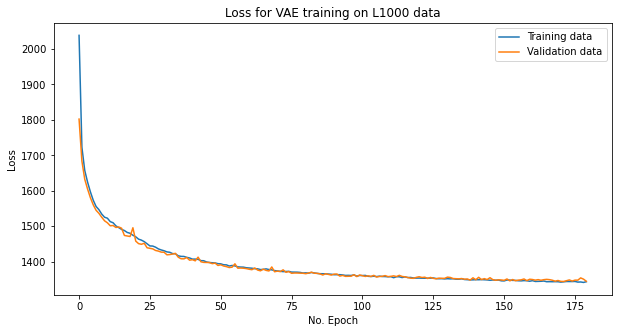

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [18]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

369/369 [==============================] - 1s 3ms/step - loss: 1338.2294


1338.2293701171875

In [19]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

3762.703212334635

<AxesSubplot:>

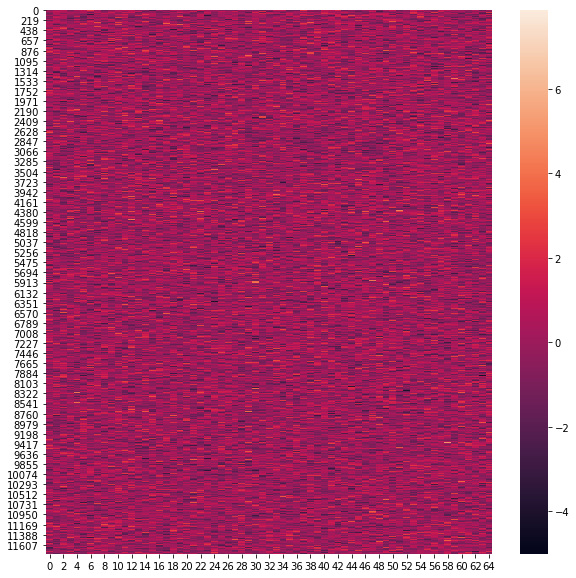

In [20]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [21]:

reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)

pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


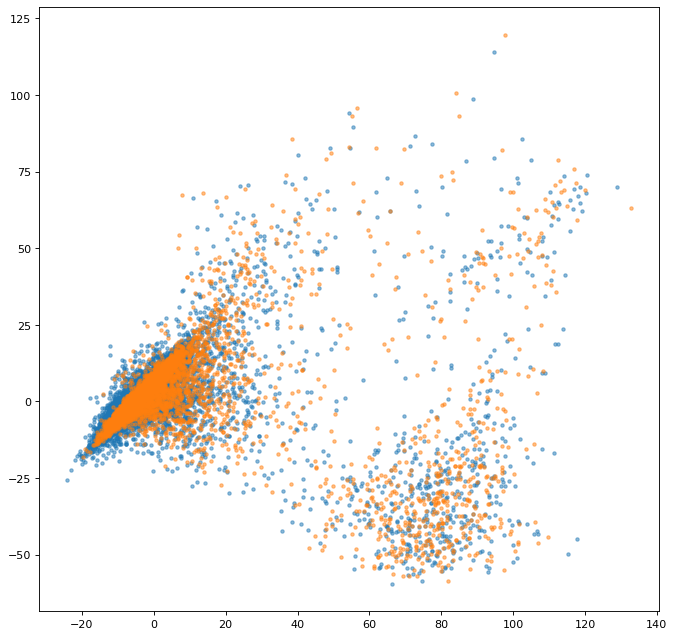

In [22]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)


In [12]:
reconstruction = decoder.predict(encoder.predict(test_features_df)[2])

In [13]:
import umap
reducer = umap.UMAP().fit(test_features_df)
original_test_embedding = reducer.transform(test_features_df)
reconstructed_test_embedding = reducer.transform(reconstruction)

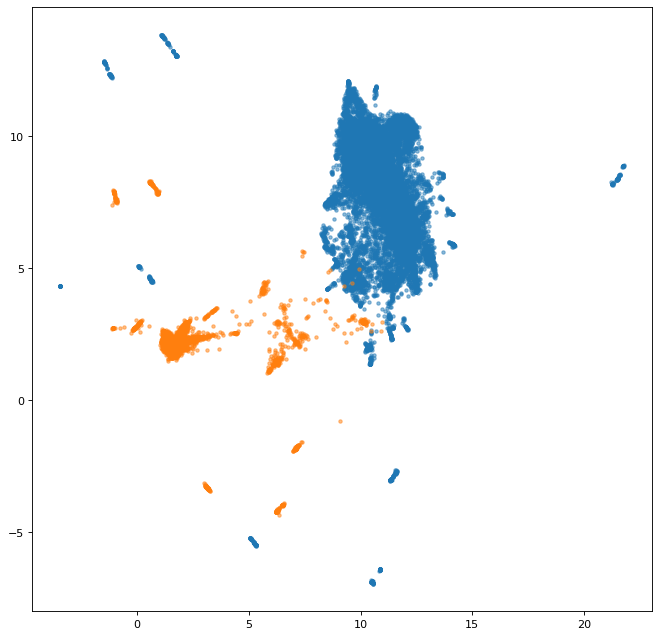

In [14]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(original_test_embedding[:,0],original_test_embedding[:,1], marker = ".", alpha = 0.5)
plt.scatter(reconstructed_test_embedding[:,0],reconstructed_test_embedding[:,1], marker = ".", alpha = 0.5)

In [23]:
decoder = L1000_vae.decoder_block["decoder"]


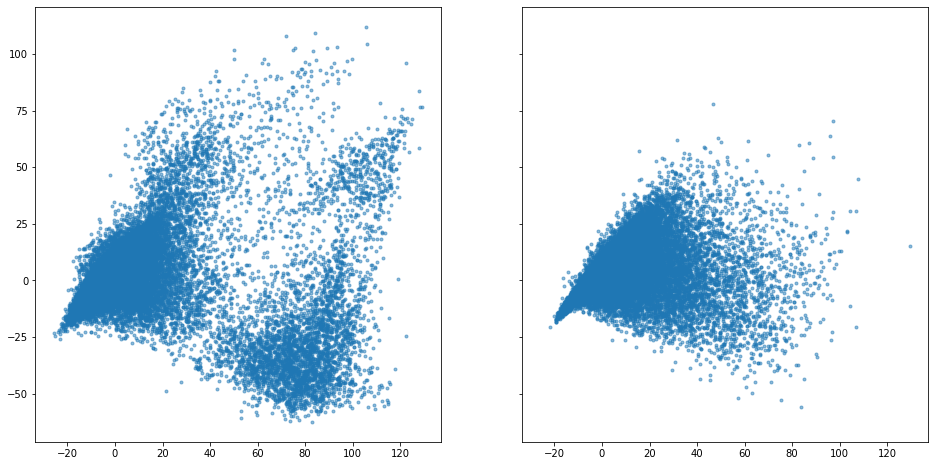

In [24]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(94440, 65)), columns=np.arange(0,65))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [25]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

196.09978897900555

In [47]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latentTwoLayer.csv")

In [28]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save('./models/L1000twolayerDecoder')

INFO:tensorflow:Assets written to: ./L1000twolayerDecoder2/assets


In [29]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
encoder.save('./models/L1000twolayerEncoder')

INFO:tensorflow:Assets written to: ./L1000twolayerEncoder2/assets
